# Introduction to Monte Carlo Simulation

The following notebook contains the code behind my Introduction to Monte Carlo Simulation tutorial.

## Imports

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import urllib3

from random import randint
from statistics import mode
from PIL import Image

## Fonts & Stylesheets

In [5]:
plt.style.use("../assets/stylesheets/soc_base.mplstyle")
main_path = "../assets/fonts/"

for x in os.listdir(main_path):
    for y in os.listdir(f"{main_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{main_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y)
            except Exception as e:
                continue

## The Dice Game

Let's define a function that simulates the throw of ten dice, and then computes the sum of the results.

In [ ]:
def throw_and_sum_n_dice(n):
    '''
    This function throws n dice and sums the results
    '''
    total = 0
    for i in range(0,n):
        throw = randint(1,6)
        total += throw
    return total

: 

: 

In [ ]:
print(f'The sum of the dice is: {throw_and_sum_n_dice(10)}')

The sum of the dice is: 42


: 

: 

Call the function a million times to check how often we would've won some money.

In [ ]:
iterations = 1000000
winning_occurances = 0
for i in range(iterations):
    total = throw_and_sum_n_dice(10)
    if total >= 40 and total <= 50:
        winning_occurances += 1

print(f'We would\'ve won money {winning_occurances:,.0f} times -- a.k.a. {winning_occurances/iterations:.3%} of the time.') 

We would've won money 203,659 times -- a.k.a. 20.366% of the time.


: 

: 

Let's imagine that we now play the game fifty times and at the end we distribute the payouts.

In [ ]:
def compute_profit_path(k, n):
    '''
    This function returns the porfit (or loss) path at the end of 
    k iterations of the game, and where we throw n dice.
    '''
    total_profit = 0
    for i in range(k):
        total = throw_and_sum_n_dice(n)
        if total >= 40 and total <= 50:
            total_profit += 10
        else:
            total_profit += -2
    return total_profit

: 

: 

In [ ]:
winnings = compute_profit_path(50,10)
print(f'On a sinlge simulation of the game 50 times we would {"win" if winnings > 0 else "lose"} {winnings} dollars')

On a sinlge simulation of the game 50 times we would win 44 dollars


: 

: 

Finally, let's perform a Monte Carlo simulation on the paths to see if we should play this game.

However, let's reduce the number of simulations to 100,000.

In [ ]:
iterations = 100000
total_profits = []
for i in range(iterations):
    total_profits.append(compute_profit_path(50,10))

: 

: 

Let's describe the results

In [ ]:
print(f'We would win some money {sum([1 for x in total_profits if x > 0])/iterations:.1%} of the time.')
print(f'Our simulation estimated that the maximum amount we could win is {max(total_profits)} dollars.')
print(f'Our simulation estimated that the maximum amount we could lose is {abs(min(total_profits))} dollars.')
most_common = mode(total_profits)
print(f'The most common outcome is that we win {most_common} dollars; which happens {sum([1 for x in total_profits if x == most_common])/iterations:.1%} of the time.')
print(f'We would win more than 10 dollars in {sum([1 for x in total_profits if x > 10])/iterations:.1%} of scenarios')
print(f'We would lose more than 10 dollars in {sum([1 for x in total_profits if x < -10])/iterations:.1%} of scenarios')

We would win some money 71.1% of the time.
Our simulation estimated that the maximum amount we could win is 212 dollars.
Our simulation estimated that the maximum amount we could lose is 88 dollars.
The most common outcome is that we win 20 dollars; which happens 13.9% of the time.
We would win more than 10 dollars in 58.0% of scenarios
We would lose more than 10 dollars in 17.7% of scenarios


: 

: 

And visualize them in a histogram

In [ ]:
profit_df = pd.DataFrame({'total_profit':total_profits})
profit_df['bin'] = pd.cut(profit_df['total_profit'], bins=[x for x in range(-90, 171, 15)])
profit_df = profit_df.groupby(['bin']).count().reset_index()
profit_df['share'] = profit_df['total_profit']/iterations

: 

: 

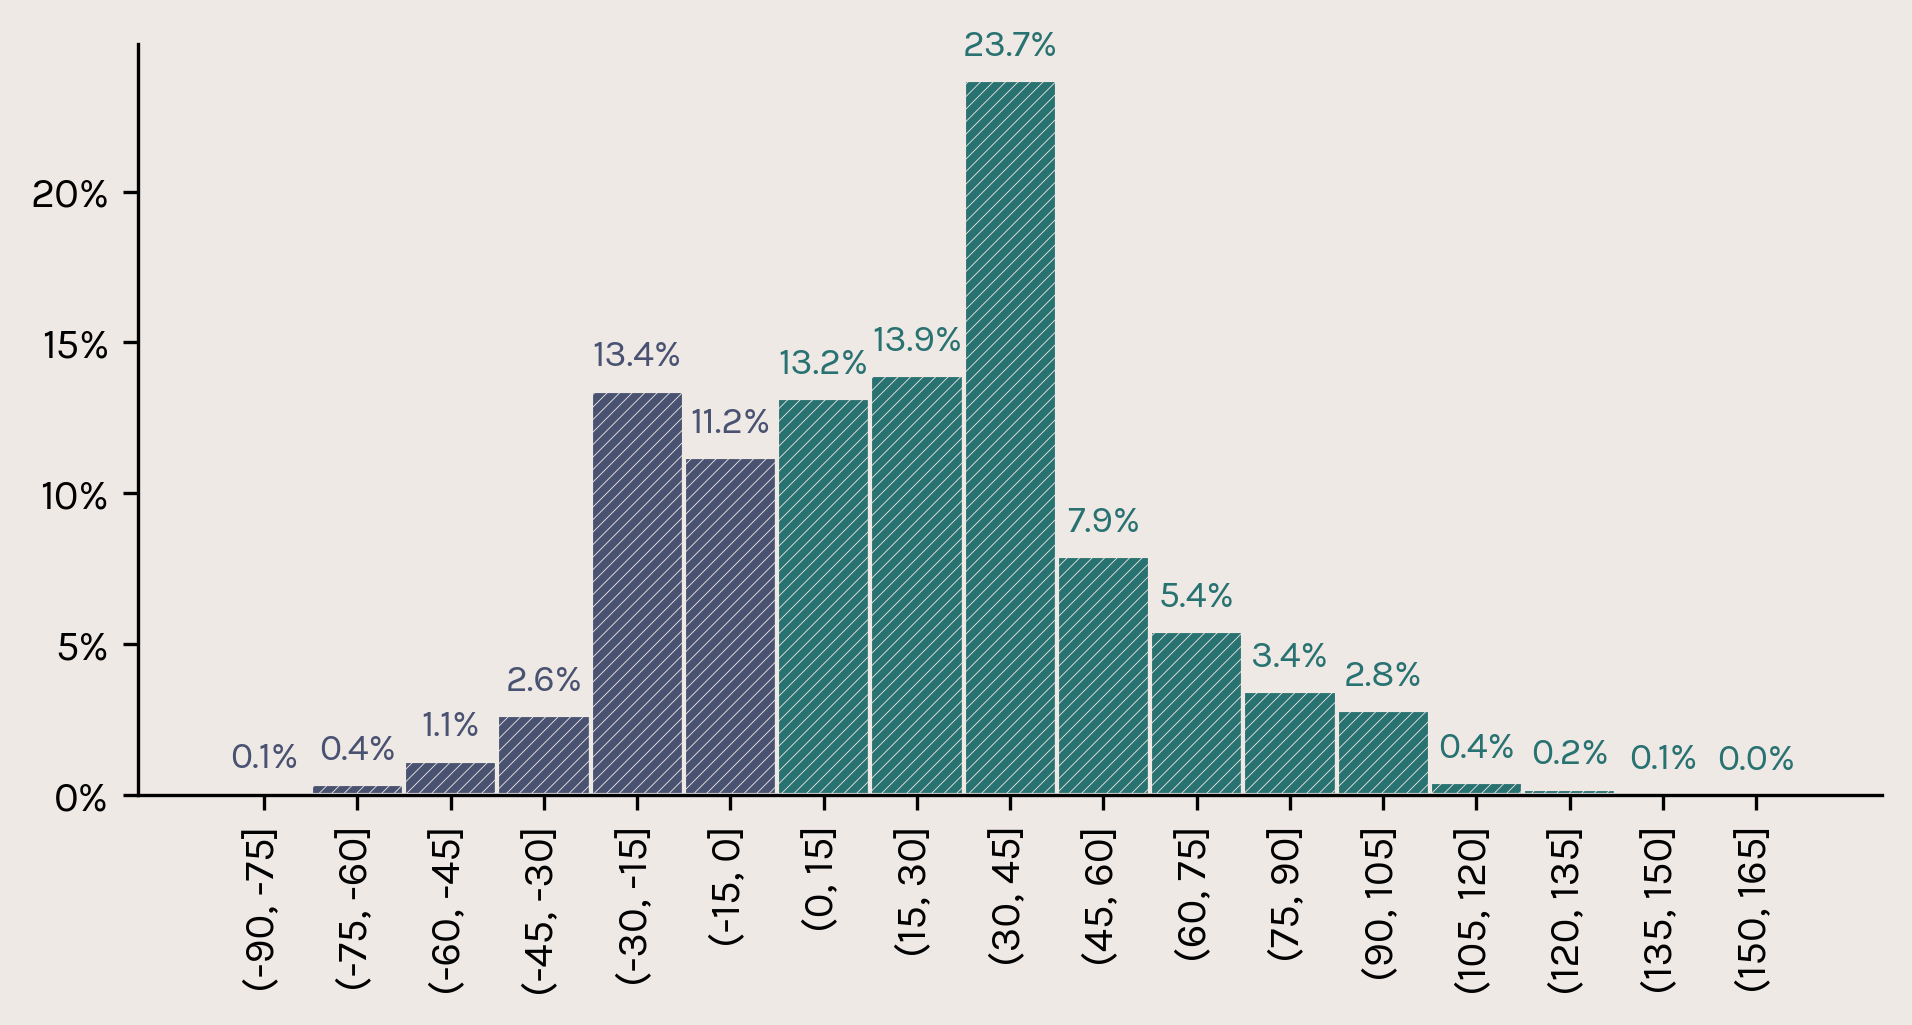

: 

: 

In [ ]:
fig = plt.figure(dpi=300)
ax = plt.subplot()
plt.rcParams['hatch.linewidth'] = 0.2

bars_ = ax.bar(profit_df.index, profit_df['share'], hatch='////////', ec=ax.get_facecolor(), width=1)
for index, b in enumerate(bars_):
    if profit_df['bin'].iloc[index].left < 0:
        color = '#495371'
    else:
        color = '#287271'
    b.set_facecolor(color)
    ax.annotate(
        xy=(index, b.get_height()), text=f'{b.get_height():.1%}',
        xytext=(0,8), textcoords='offset points', 
        ha='center', va='center',
        color=color, size=9
    )

ticks = ax.set_xticks(
    ticks=profit_df.index,
    labels=profit_df['bin'],
    rotation=90
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
plt.savefig(
	"figures/dice_game_hist.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

## Applying Monte Carlo to Football data

### Loading the data

The following dataset contains all of the shots taken during the Champions League Group stage.

In [ ]:
df = pd.read_csv('data/ucl_shot_data.csv', index_col=0)
df.head()

NameError: name 'pd' is not defined

: 

: 

In [ ]:
(.9)**10

0.3486784401000001

: 

: 